#はじめに

9月末までsignateにて、「医学論文の自動仕分けチャレンジ」という、論文のデータ群から医学論文を抽出するコンペに参加した。\
コンペでは、SciBERTを含めた深層学習モデルを使って医学論文をpositiveとして二値分類を行い予測を試した。結果は最終score: 87となり、メダル圏内に入らなかったものの、自然言語処理の知見を得ることができた。\
<a href="https://signate.jp/competitions/471">医学論文の自動仕分けチャレンジ</a>

\
今回は、BERTの代わりに、tf-idfを用いて医学論文の偏りのあるデータ群の二値分類を行う。その際に「**学習データのサンプリング方法によって精度は変わるのか**」、「**モデル学習時のmetricによって精度が変わるのか**」といった観点から再度検証した。\
結論としては、f7値を目標に予測を行う場合には、非サンプリング、undersamplingの手法が有効であった。一方でf0.1値を目標に予測を行う場合には、over,undersamplingを組み合わせたsmoteennが有効であった。\
metricの検証では、aucとbinary_loglossを比較した。aucよりもloglossをmetricに設定することで、f値の精度上昇がおおむね見込めるものの、精度が拮抗した場合もあるため、両方の精度を見ることが望ましいと考えた。

#検証0: tf-idfによる前処理

tf-idfは**総文書内の、ある文書における単語の重要度**を表し、tf値とidf値の積で求められる。
$$tfidf_{w_i,d_j} = tf_{w_i,d_j} ×idf_{w_i}$$
$$tf_{w_i,d_j} = 単語iの文書dにおける出現回数/文書dにおける全単語の出現回数の和$$
$$idf=log(総文書数/ある単語iを含む文書の数)+1$$

tf値では文書dの中にどの程度単語iが含まれているかを表現している。一方でidf値では単語iがレアかどうかを表している。\
まとめると、tf-idf値は文書dの中に含まれる単語iがどの程度レアで且ついくつ含まれているかを表している。

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import re
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r':', ' ', replaced_text)
    replaced_text = re.sub(
        r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

In [4]:
df = pd.read_csv("/content/drive/My Drive/SRWS-PSG/train.csv")
df[df["id"]==2488]["judgement"] = df[df["id"]==7708]["judgement"] = 0 #誤ったラベルの訂正

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#tfidfモデルの宣言
#max_features=Nで単語数を設定できるが、計算時間がそこまで長くなかったので、デフォルトで良いと思う。
vectorizer = TfidfVectorizer()

#tfidf化するabstractカラムが空であればレコードを削除
df = df[~df["abstract"].isna()]

#文書をクリーニング->tfidf化
df["abstract"] = df["abstract"].apply(lambda x: clean_text(x))
df_vec = vectorizer.fit_transform(df["abstract"])
df.info()
print("tf-idf vector (text_count, word_vector): {}".format(df_vec.shape))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22755 entries, 0 to 27144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         22755 non-null  int64 
 1   title      22755 non-null  object
 2   abstract   22755 non-null  object
 3   judgement  22755 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 888.9+ KB
tf-idf vector (text_count, word_vector): (22755, 67071)


TSNEにてword_vectorを2次元に圧縮して分布を可視化する。

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
df_embed = tsne.fit_transform(df_vec)

In [16]:
df_embed.shape
ddf = pd.concat([df, pd.DataFrame(df_embed, columns=["col1", "col2"])], axis=1)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 27144
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22755 non-null  float64
 1   title      22755 non-null  object 
 2   abstract   22755 non-null  object 
 3   judgement  22755 non-null  float64
 4   col1       22755 non-null  float32
 5   col2       22755 non-null  float32
dtypes: float32(2), float64(2), object(2)
memory usage: 1.2+ MB


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

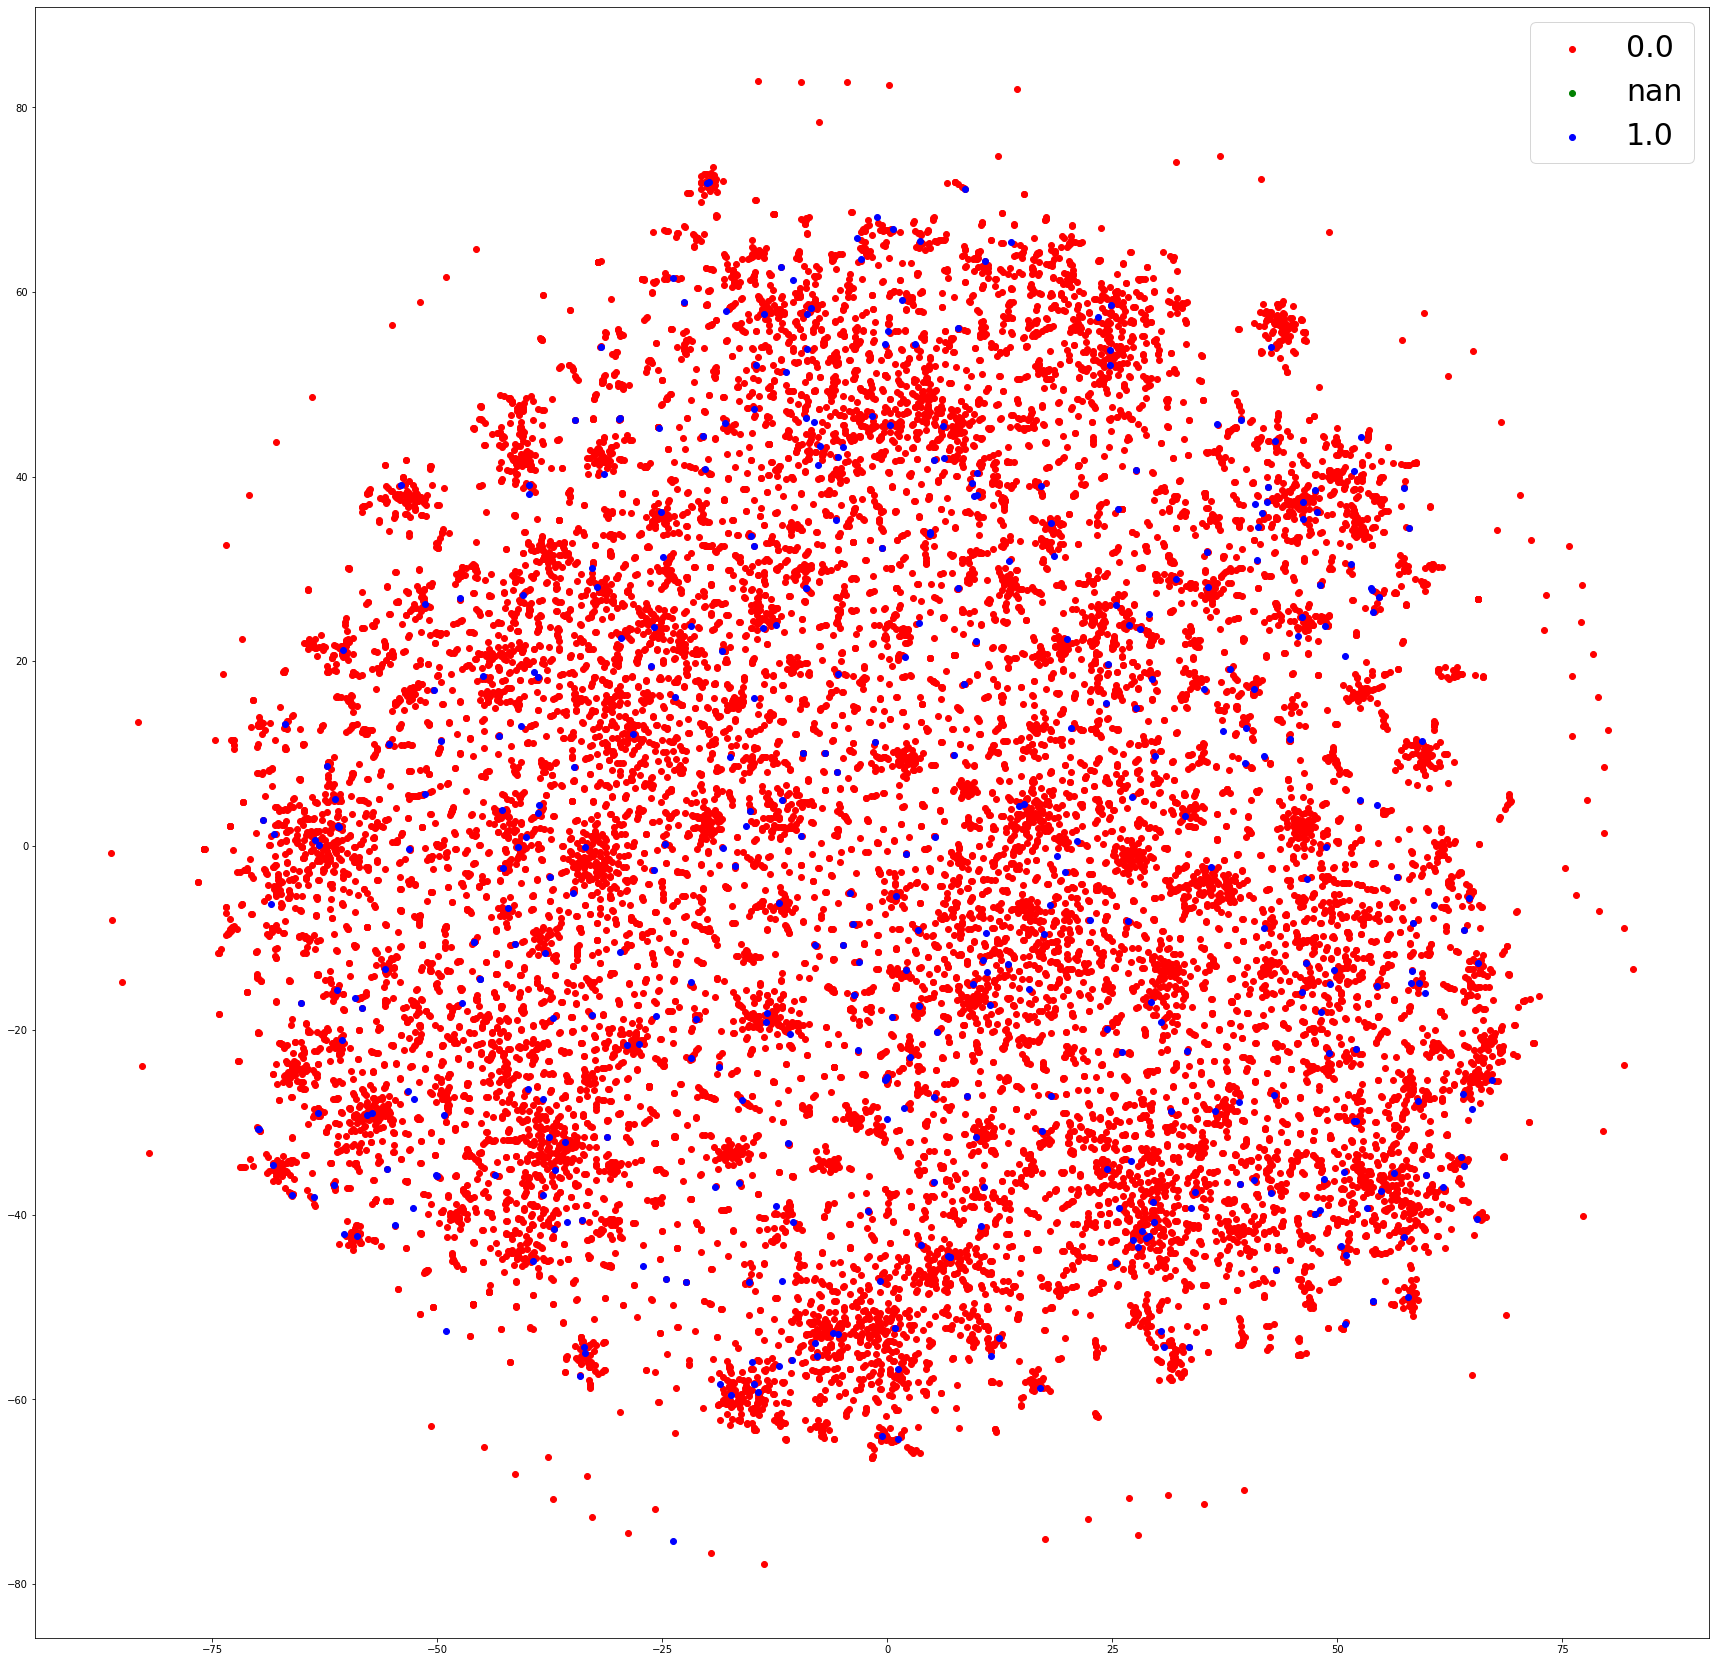

In [18]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]

article_list = ddf["judgement"].unique()

plt.figure(figsize = (30, 30))
for i , v in enumerate(article_list):
    tmp_df = ddf[ddf["judgement"] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])

plt.legend(fontsize = 30)

In [19]:
print("minor / major: {}".format(len(ddf[ddf["judgement"]==1]) / len(ddf)))

minor / major: 0.01927656196847715


**赤:多数派、青:少数派**\
検出したい少数派がまばらに存在しており、少数派のクラスタがみられない。



#検証1: サンプリングによるデータセットの変化の違い

今回のデータセットでは、多数派・少数派のデータ数が不均衡である。\
不均衡なデータセットに用いられる手法として、以下があげられる。


1.   over-sampling
2.   under-sampling
3.   over,under-sampling

**over-sampling**では、少数派のデータの水増しを行い多数派のデータ数に近づける。smoteやborderlineSmoteのように、少数派のデータの近くに、新たな疑似的少数派データを追加するといった方法が提案されている。
\
**under-sampling**では多数派のデータを絞ることで少数派のデータ数に近づける。多数派データが減少することで、データ量が不足することが問題となる。それを解決するために、baggingと組み合わせた方法が提案されている。\
また、両者を組み合わせた**over,under-sampling**といった手法も存在し、smoteennなどが該当する。

##検証1-1: smoteによるoversampling

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
df_smote_vec, df_smote_label = sm.fit_sample(df_vec, df["judgement"])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
df_smote_embed = tsne.fit_transform(df_smote_vec)

In [ ]:
print(df_smote_embed[:][0].shape, df_smote_label.shape)
df_smote = pd.DataFrame([])
df_smote["judgement"] = df_smote_label
df_smote = pd.concat([df_smote, pd.DataFrame(df_smote_embed, columns=["col1", "col2"])], axis=1)
df_smote.info()

(2,) (44490,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44490 entries, 0 to 44489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   judgement  44490 non-null  int64  
 1   col1       44490 non-null  float32
 2   col2       44490 non-null  float32
dtypes: float32(2), int64(1)
memory usage: 695.3 KB


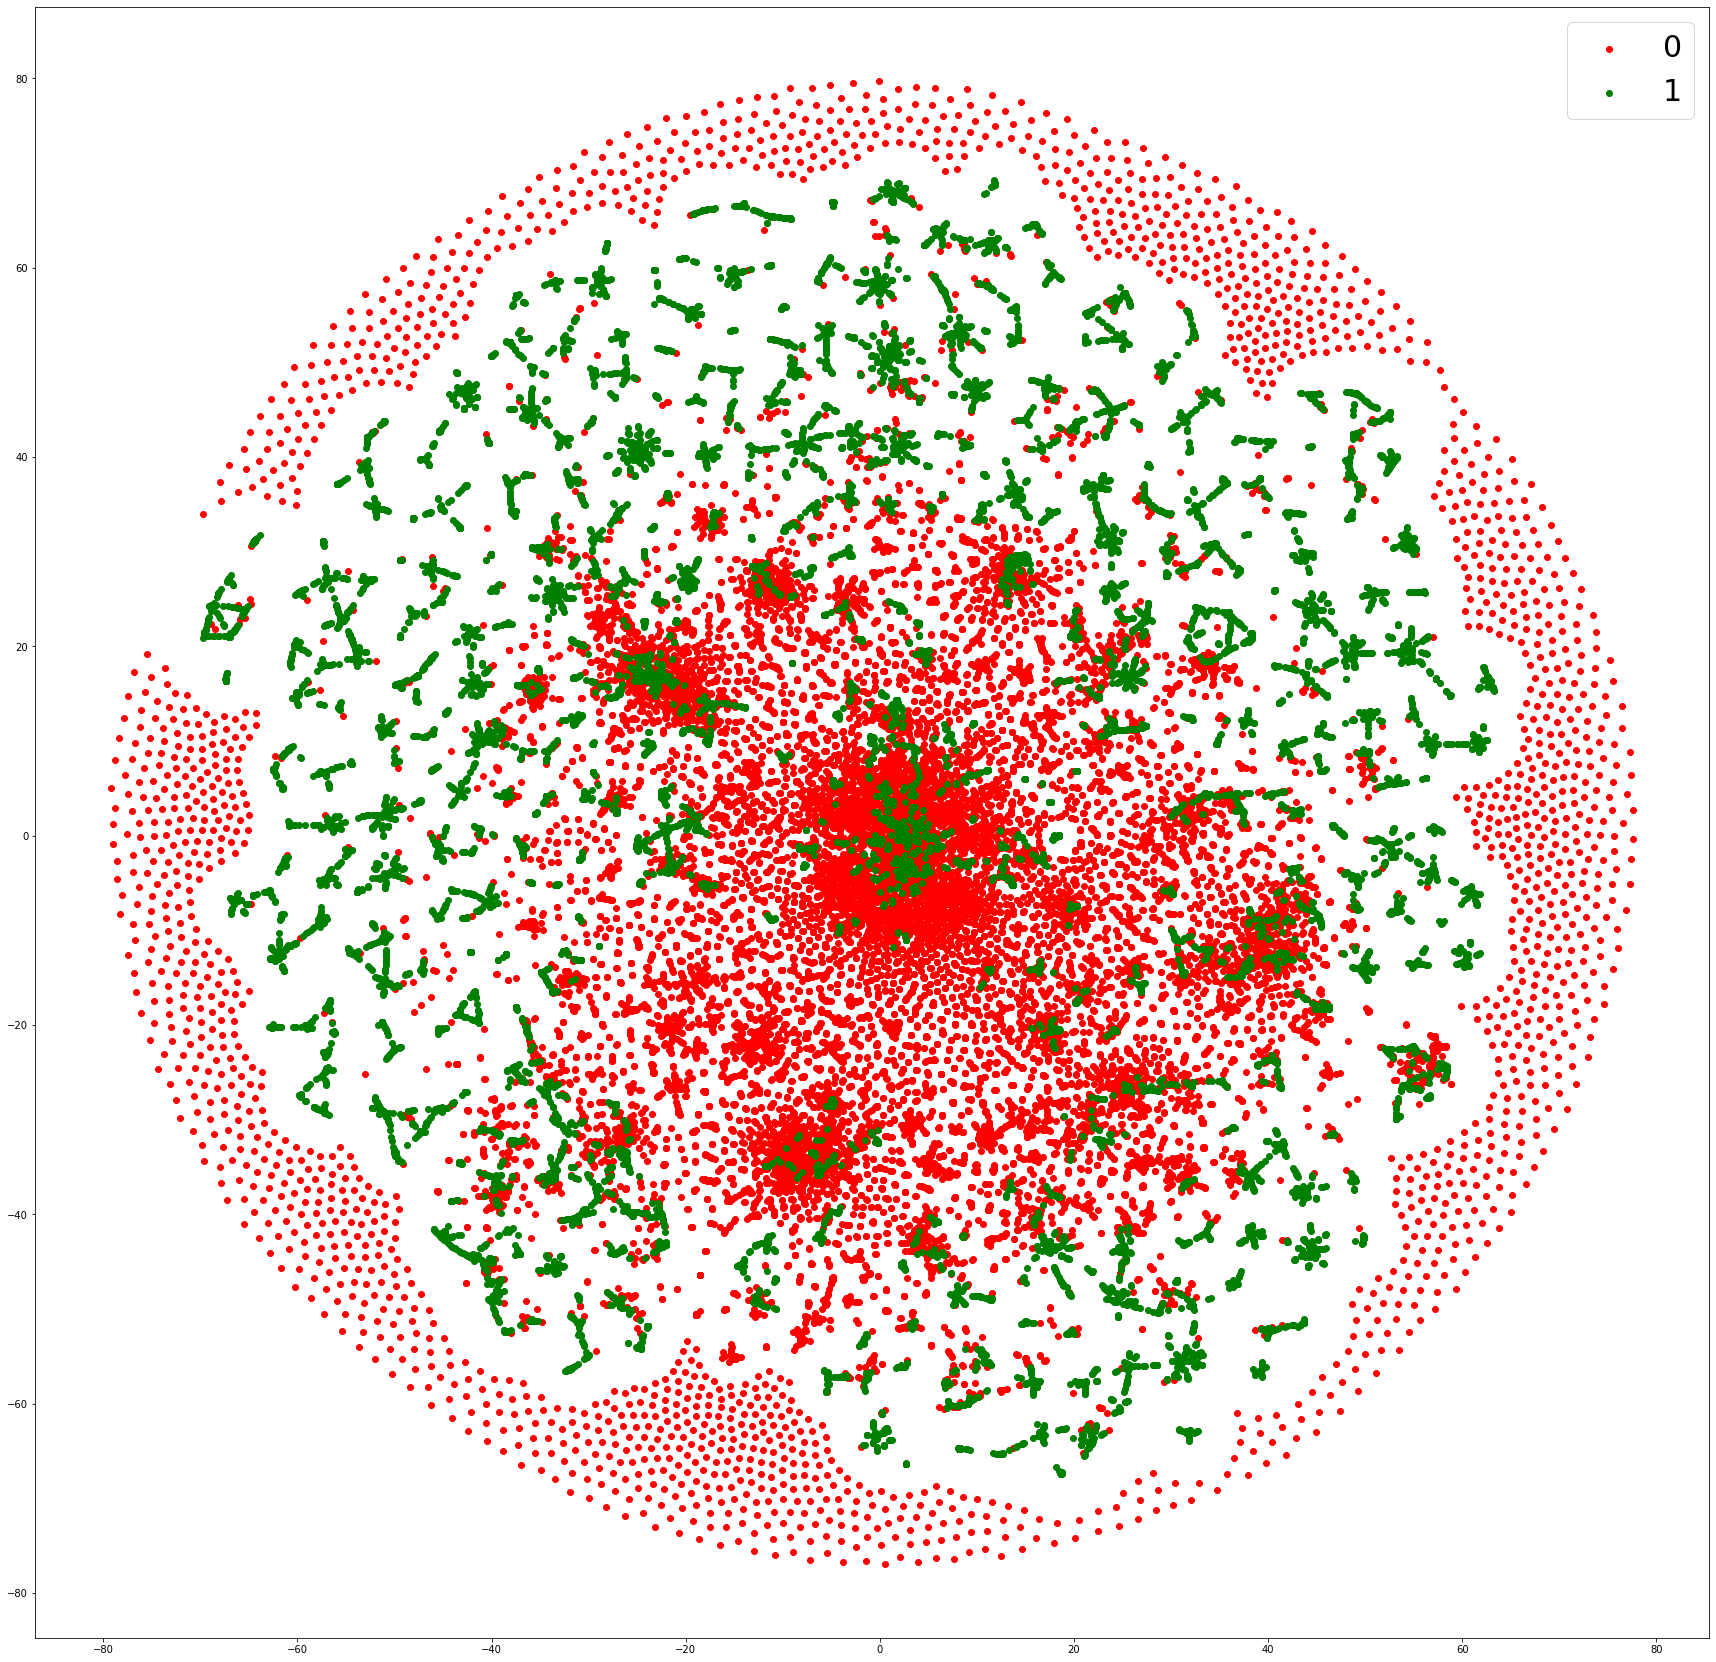

In [ ]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]

article_list = df_smote["judgement"].unique()

plt.figure(figsize = (30, 30))
for i , v in enumerate(article_list):
    tmp_df = df_smote[df_smote["judgement"] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])

plt.legend(fontsize = 30)

緑(少数派)の数が多くなっていることが確認できる。\
smoteでは、水増しするデータを作成するための基準となる少数派データを、選択する方法はランダムとなっているため、水増しされた緑は偏りなく増加している。

##検証1-2: BorderlineSmoteによるoversampling

In [20]:
from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state = 0)# kind = 'borderline-1'
df_bsmote = pd.DataFrame([])
df_bsmote.info()
df_bsmote_vec, df_bsmote_label = bsmote.fit_sample(df_vec, df["judgement"])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
df_bsmote_embed = tsne.fit_transform(df_bsmote_vec)

In [22]:
print(df_bsmote_embed[:][0].shape, df_bsmote_label.shape)
df_bsmote["judgement"] = df_bsmote_label
df_bsmote = pd.concat([df_bsmote, pd.DataFrame(df_bsmote_embed, columns=["col1", "col2"])], axis=1)
df_bsmote.info()

(2,) (44490,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44490 entries, 0 to 44489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   judgement  44490 non-null  int64  
 1   col1       44490 non-null  float32
 2   col2       44490 non-null  float32
dtypes: float32(2), int64(1)
memory usage: 695.3 KB


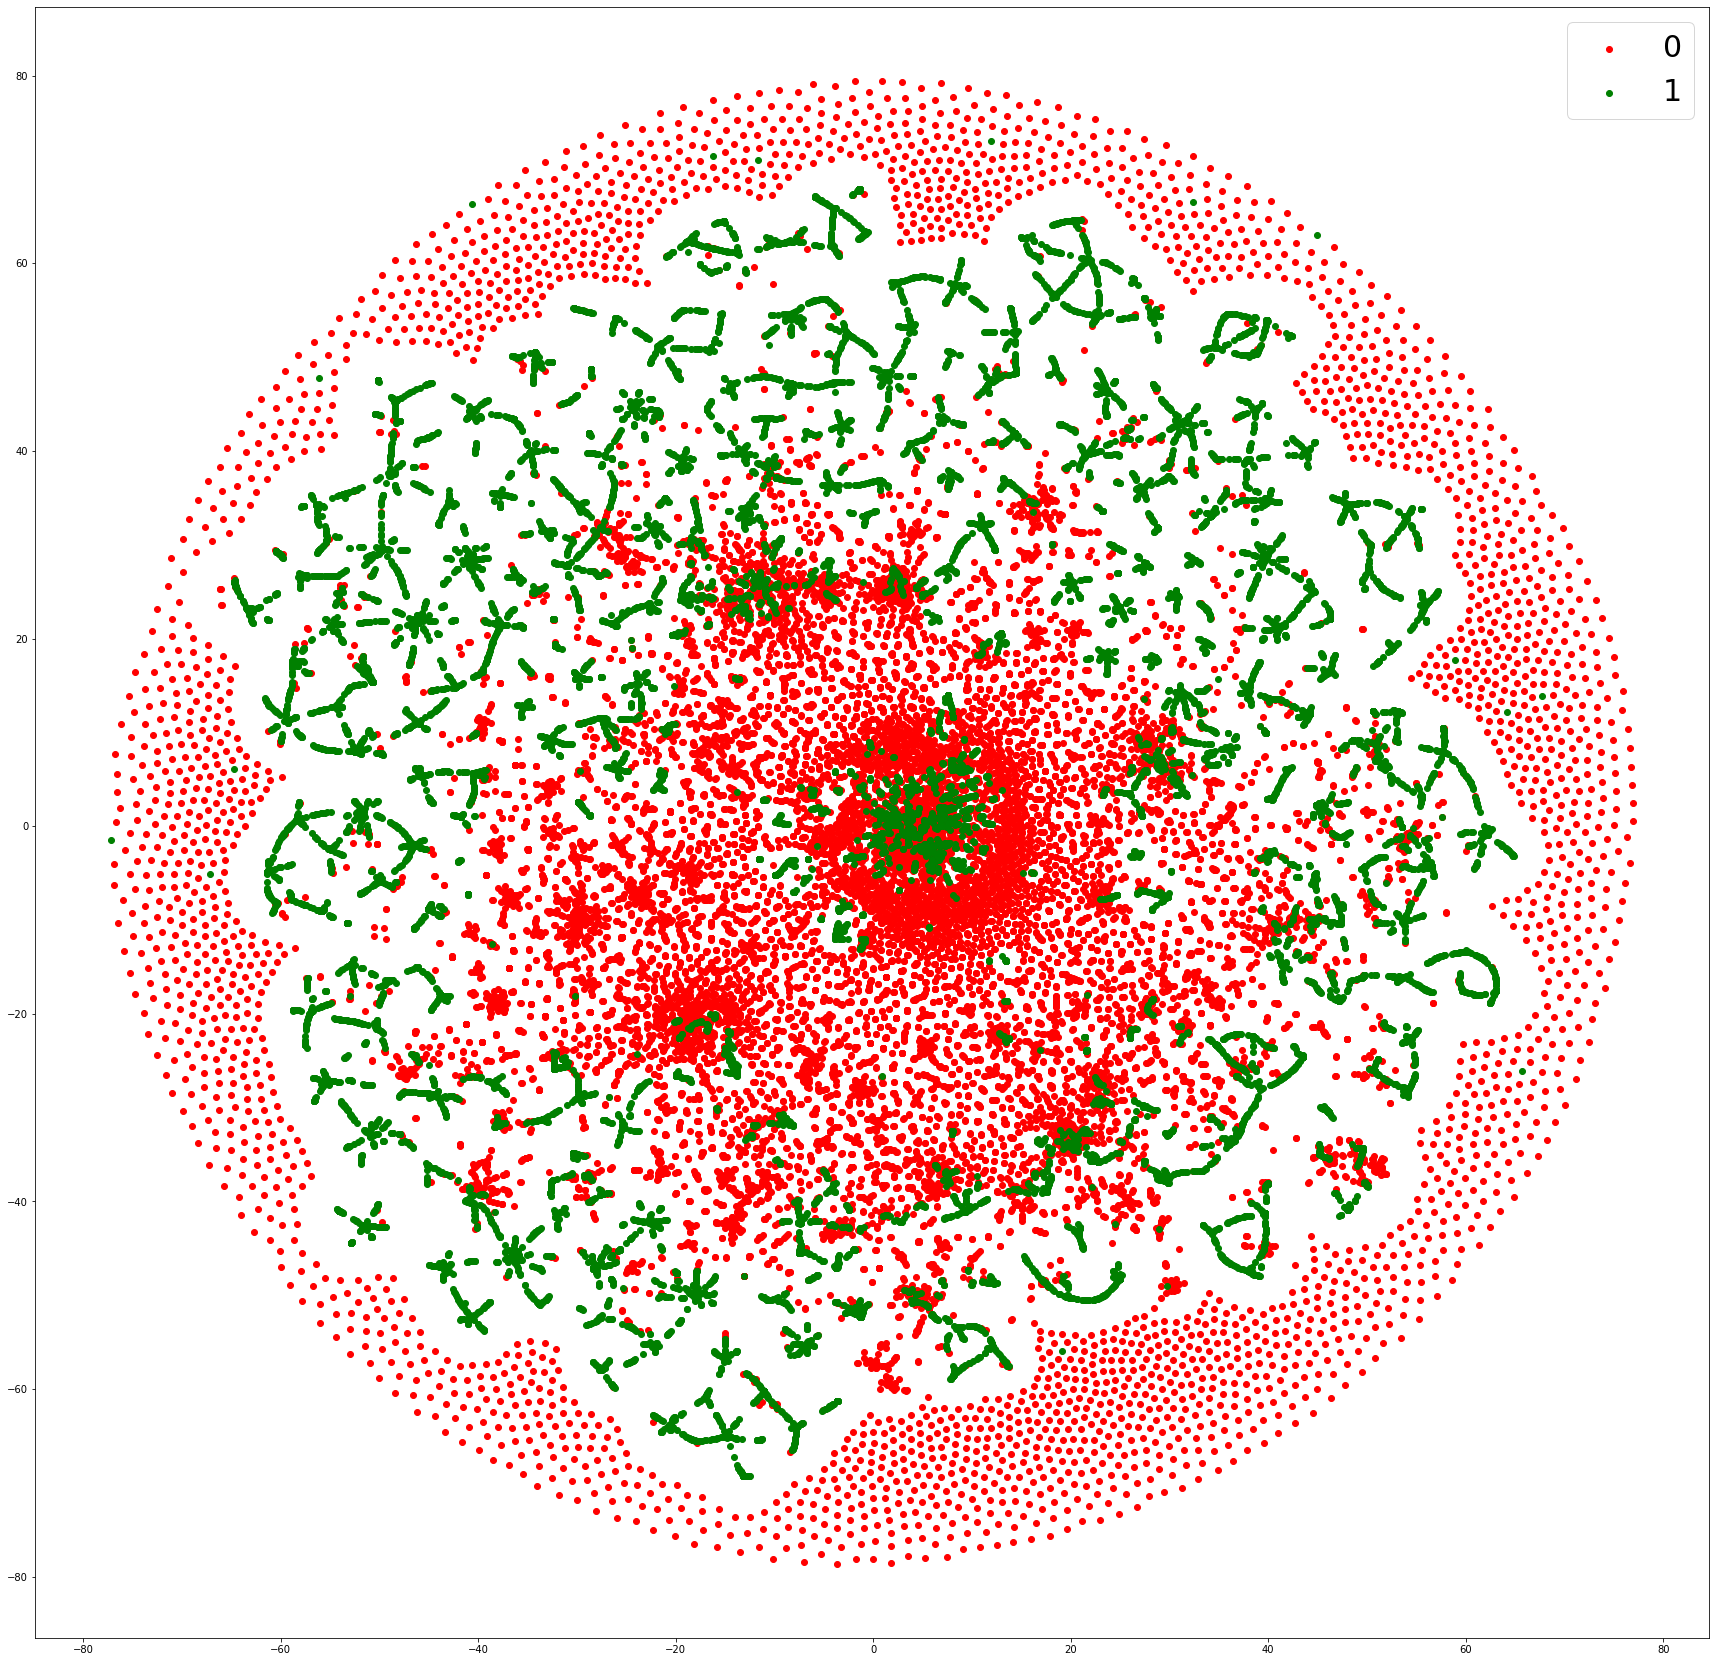

In [23]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]

article_list = df_bsmote["judgement"].unique()

plt.figure(figsize = (30, 30))
for i , v in enumerate(article_list):
    tmp_df = df_bsmote[df_bsmote["judgement"] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])

plt.legend(fontsize = 30)

In [24]:
print("df_bsmote judge count\njudge1: {}, judge0: {}".format(len(df_bsmote[df_bsmote["judgement"]==1]), len(df_bsmote[df_bsmote["judgement"]==0])))

df_bsmote judge count
judge1: 22245, judge0: 22245


緑(少数派)の数が多くなっていることが確認できる。
borderlineSmoteでは、水増しするデータを作成するための基準となる少数派データを選択するとき、周りに多数派データが多いものを選択する。そのため、図の中央の緑クラスタなどで見られるように、赤との境界線をきれいに描くように緑が水増しされている。\
~~実はsmoteとあまり差異がみられないかも…~~

##検証1-3: smoteennによるoversampling

In [ ]:
from imblearn.combine import SMOTEENN
smtn = SMOTEENN(random_state=0)
df_smoteenn = pd.DataFrame([])
df_smoteenn.info()
df_smoteenn_vec, df_smoteenn_label = smtn.fit_sample(df_vec, df["judgement"])

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
df_smoteenn_embed = tsne.fit_transform(df_smoteenn_vec)

In [ ]:
print(df_smoteenn_embed[:][0].shape, df_smoteenn_label.shape)
df_smoteenn["judgement"] = df_smoteenn_label
df_smoteenn = pd.concat([df_smoteenn, pd.DataFrame(df_smoteenn_embed, columns=["col1", "col2"])], axis=1)
df_smoteenn.info()

(2,) (29213,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29213 entries, 0 to 29212
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   judgement  29213 non-null  int64  
 1   col1       29213 non-null  float32
 2   col2       29213 non-null  float32
dtypes: float32(2), int64(1)
memory usage: 456.6 KB


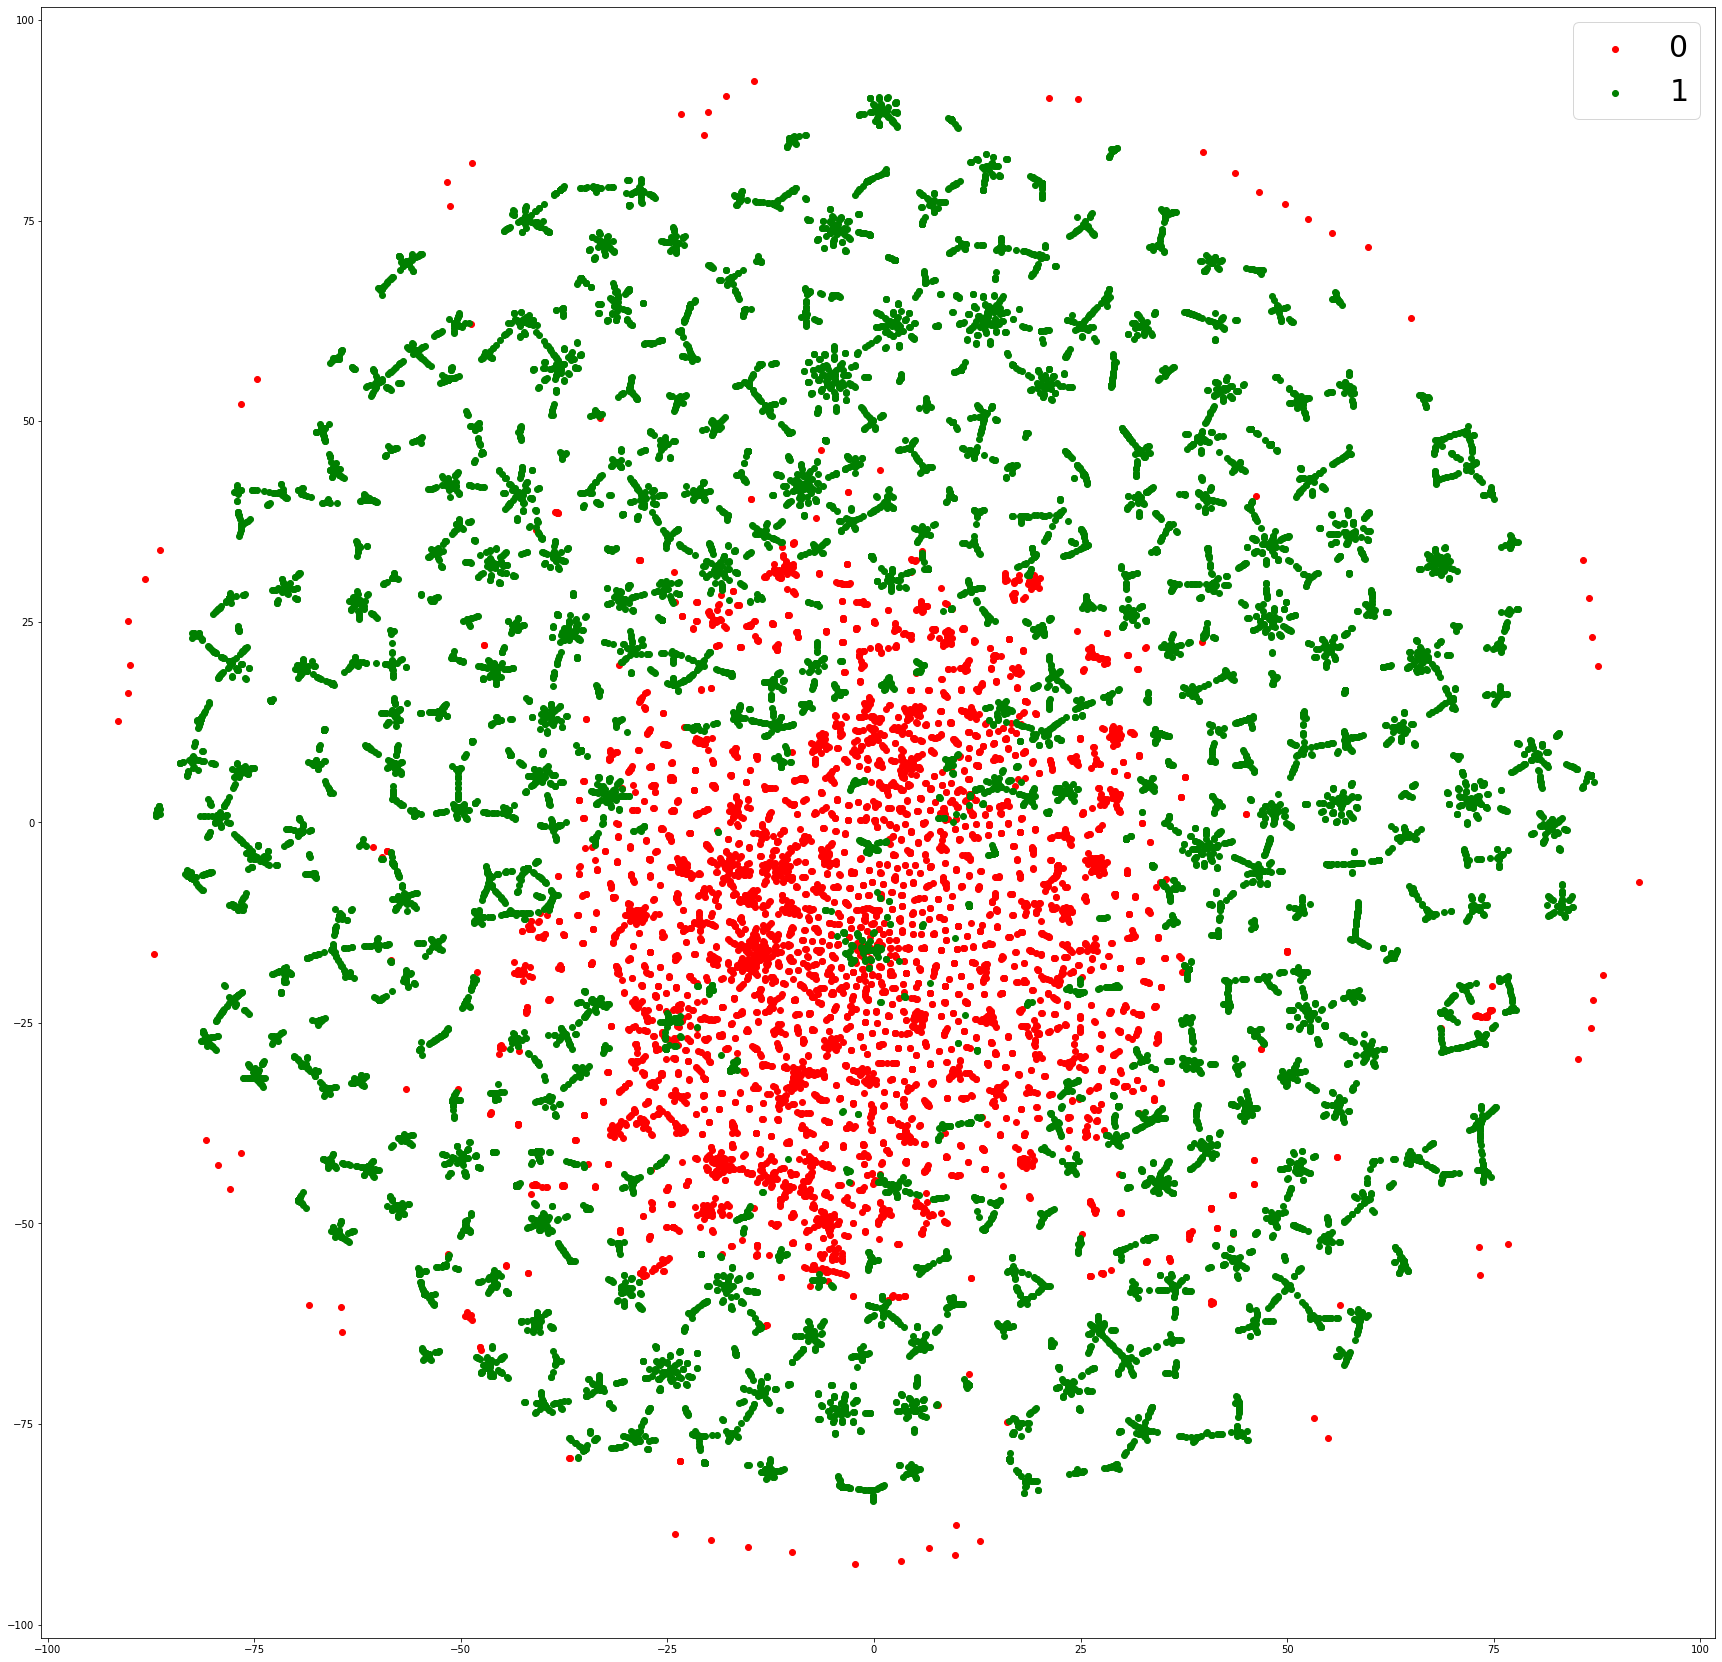

In [ ]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]

article_list = df_smoteenn["judgement"].unique()

plt.figure(figsize = (30, 30))
for i , v in enumerate(article_list):
    tmp_df = df_smoteenn[df_smoteenn["judgement"] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])

plt.legend(fontsize = 30)

In [ ]:
print("df_smoteenn judge count\njudge1: {}, judge0: {}".format(len(df_smoteenn[df_smoteenn["judgement"]==1]), len(df_smoteenn[df_smoteenn["judgement"]==0])))

df_smoteenn judge count
judge1: 22245, judge0: 6968


少数派の数が多くなり、且つ多数派が減少していることが確認できる。
smoteennでは、少数派を水増しするときに、多数派をノイズとして除去するため、多数派の数の減少がみられる。\
少数派を取りこぼさない指標**recall**に重きを置く場合には、赤が消えて緑が増えることで、FNが減る可能性があり精度が見込める。しかし、**precision**は、誤った少数派FPを増加する可能性から精度が落ちる可能性がある。

##検証1-4: undersampling

In [25]:
# from imblearn.over_sampling import BorderlineSMOTE
# bsmote = BorderlineSMOTE(random_state = 0)# kind = 'borderline-1'
# df_bsmote = pd.DataFrame([])
# df_bsmote.info()
# df_bsmote_vec, df_bsmote_label = bsmote.fit_sample(df_vec, df["judgement"])

from imblearn.under_sampling import RandomUnderSampler
import numpy as np

negative_count = df["judgement"].value_counts()[1]
strategy = {0:negative_count*10, 1:negative_count}

rus = RandomUnderSampler(random_state=0, sampling_strategy = strategy)
df_usampled_vec, df_usampled_label = rus.fit_resample(df_vec, df["judgement"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
df_usampled_embed = tsne.fit_transform(df_usampled_vec)

In [29]:
print(df_usampled_embed[:][0].shape, df_usampled_label.shape)
df_usampled = pd.DataFrame([])
df_usampled.info()
df_usampled["judgement"] = df_usampled_label
df_usampled = pd.concat([df_usampled, pd.DataFrame(df_usampled_embed, columns=["col1", "col2"])], axis=1)
df_usampled.info()

(2,) (5610,)
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5610 entries, 0 to 5609
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   judgement  5610 non-null   int64  
 1   col1       5610 non-null   float32
 2   col2       5610 non-null   float32
dtypes: float32(2), int64(1)
memory usage: 87.8 KB


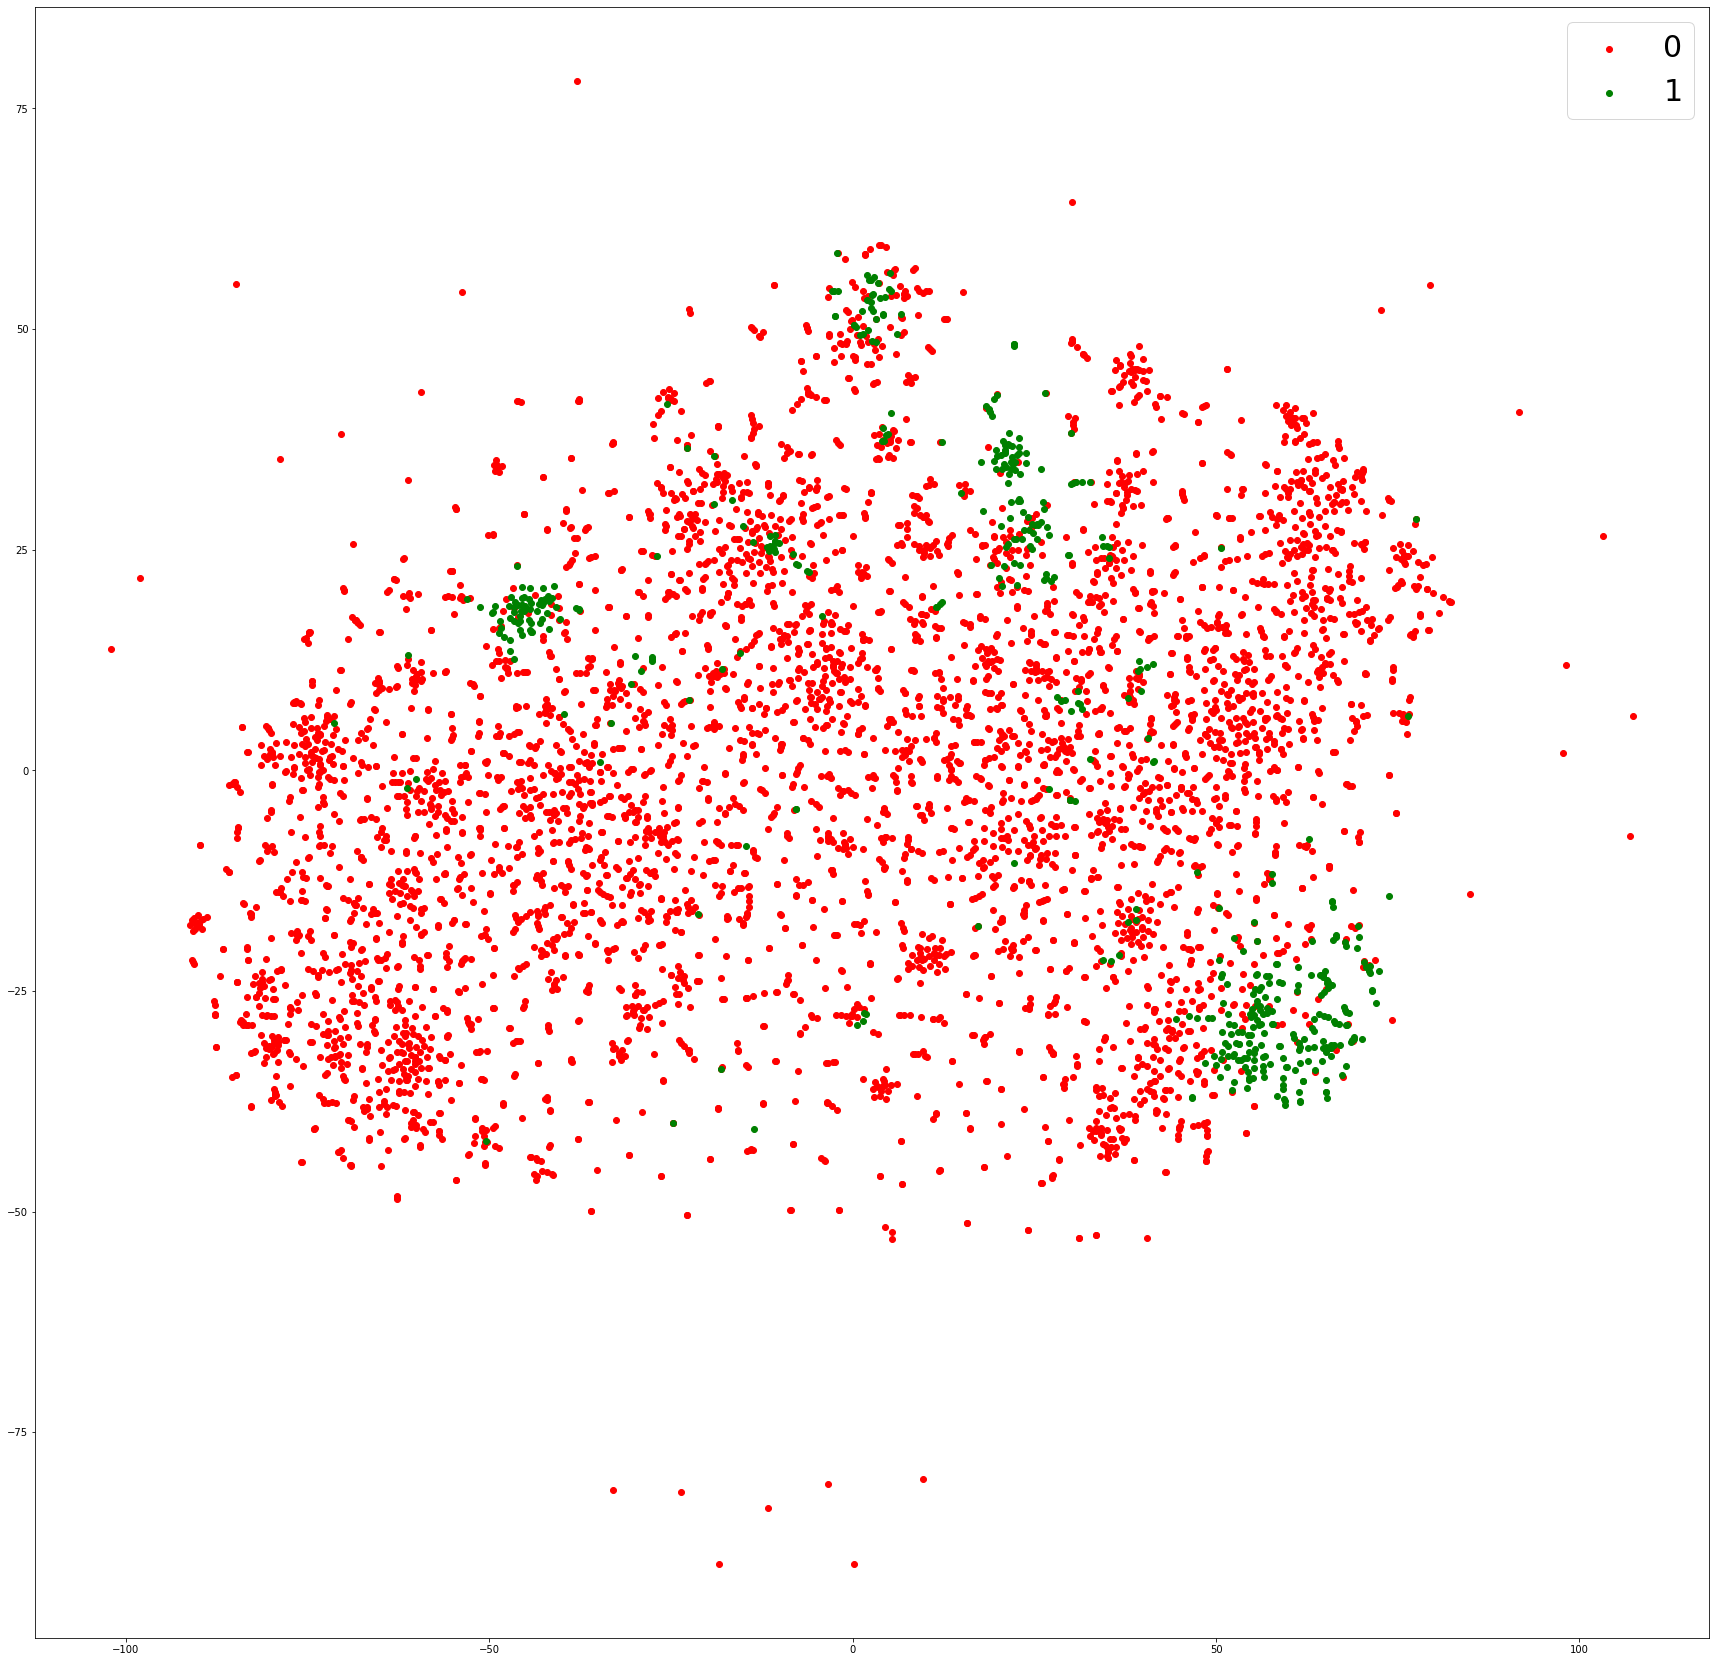

In [30]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink"]

article_list = df_usampled["judgement"].unique()

plt.figure(figsize = (30, 30))
for i , v in enumerate(article_list):
    tmp_df = df_usampled[df_usampled["judgement"] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])

plt.legend(fontsize = 30)

In [31]:
print("df_usampled judge count\njudge1: {}, judge0: {}".format(len(df_usampled[df_usampled["judgement"]==1]), len(df_usampled[df_usampled["judgement"]==0])))

df_usampled judge count
judge1: 510, judge0: 5100


undersamplingを行うことで、多数派データの減少がみられる。\
また、データ数が減ったことで、少数派のデータクラスタが鮮明に可視化させる。今回の場合、大きな緑クラスタが4～6個存在することが確認できる。

#検証2: LightGBMによる予測(smote, borderlineSmote, smoteenn, undersampling)

##検証2-0:非Oversamplingのデータセットによるlightgbm予測

データ群をtrain, valid, predに分割する。\
2-1以降の検証でもこの変数を用いる。

In [6]:
from sklearn.model_selection import train_test_split
print(df_vec.shape, df["judgement"].shape)

#train, valid, predを[0.56,0.14,0.3]に分割
X_train, X_pred, y_train, y_pred = train_test_split(df_vec, df["judgement"], test_size=0.3, shuffle=True, random_state=0, stratify=df["judgement"])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0, stratify=y_train)

(22755, 67071) (22755,)


In [9]:
#predデータの予測および、fbeta値の算出関数(lightgbmのmetricに存在しなかったため)
from sklearn.metrics import fbeta_score
import numpy as np

def cul_pred_fbeta(model, X_pred, y_pred, beta):
  pred = model.predict(X_pred)
  print("")
  print("fbeta{}: {}".format(beta, fbeta_score(np.round(pred), y_pred, beta=beta)))

学習・予測ではlightgbmを用いた。\
サンプリングの違いを評価するために、predデータの予測に対する精度として、fbeta0.1, fbeta0.5,　fbeta3, fbeta7の指標を用いて測定した。
$$f_{beta} = (1+ \beta^2) \frac{precision・recall}{\beta^2・precision + recall}$$
betaが1より小さいときはrecall重視となり、1より大きいときはprecision重視となる。

In [61]:
#lightgbmによる学習→予測
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

#auc, loglossの違いでf-beta7(recall重視)にどう影響するか
params_metric = ["auc", "binary_logloss"]


evals_results = {}

for metric in params_metric:
  print("metric: {}".format(metric))
  params = {
      # 二値分類問題, balanced: 偏りのあるデータ対策でclassごとにweightをつける
      "objective": "binary",
      "metric": metric,
      "class_weight": "balanced",
  }

  evals_result = {}

  gbm = lgb.train(params,
                  lgb_train,
                  valid_sets = [lgb_train, lgb_valid],
                  valid_names = [ 'train', 'eval'],
                  num_boost_round = 500,
                  early_stopping_rounds = 10,
                  verbose_eval = 10,
                  evals_result = evals_result
                )
  
  evals_results[metric] = evals_result
  cul_pred_fbeta(gbm, X_pred, y_pred, 7)
  cul_pred_fbeta(gbm, X_pred, y_pred, 3)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.5)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.1)
  print("-"*60)

metric: auc
Training until validation scores don't improve for 10 rounds.
[10]	train's auc: 0.997852	eval's auc: 0.964328
[20]	train's auc: 0.999893	eval's auc: 0.977388
[30]	train's auc: 1	eval's auc: 0.980399
Early stopping, best iteration is:
[28]	train's auc: 1	eval's auc: 0.980246

fbeta7: 0.8346905537459284

fbeta3: 0.7118055555555556

fbeta0.5: 0.3110773899848255

fbeta0.1: 0.26982472144393044
------------------------------------------------------------
metric: binary_logloss
Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0368341	eval's binary_logloss: 0.065
[20]	train's binary_logloss: 0.0207871	eval's binary_logloss: 0.0572105
[30]	train's binary_logloss: 0.0125214	eval's binary_logloss: 0.0551508
[40]	train's binary_logloss: 0.00792189	eval's binary_logloss: 0.0545491
[50]	train's binary_logloss: 0.00512907	eval's binary_logloss: 0.0556842
Early stopping, best iteration is:
[42]	train's binary_logloss: 0.00722092	eval's binary_log

##検証2-1:Smoteのデータセットによるlightgbm予測

In [63]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print("X_train, y_train: {}, {} ->after smote: {}, {}".format(X_train.shape, y_train.shape, X_train_smote.shape, y_train_smote.shape))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train, y_train: (12742, 67071), (12742,) ->after smote: (24912, 67071), (24912,)


In [65]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_smote, y_train_smote)
lgb_valid = lgb.Dataset(X_valid, y_valid)

#auc, loglossの違いでf-beta7(recall重視)にどう影響するか
params_metric = ["auc", "binary_logloss"]


evals_results = {}

for metric in params_metric:
  print("metric: {}".format(metric))
  params = {
      # 二値分類問題, balanced: 偏りのあるデータ対策でclassごとにweightをつける
      "objective": "binary",
      "metric": metric,
      "class_weight": "balanced",
  }

  evals_result = {}

  gbm = lgb.train(params,
                  lgb_train,
                  valid_sets = [lgb_train, lgb_valid],
                  valid_names = [ 'train', 'eval'],
                  num_boost_round = 500,
                  early_stopping_rounds = 10,
                  verbose_eval = 10,
                  evals_result = evals_result
                )
  
  evals_results[metric] = evals_result
  cul_pred_fbeta(gbm, X_pred, y_pred, 7)
  cul_pred_fbeta(gbm, X_pred, y_pred, 3)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.5)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.1)
  print("-"*60)

metric: auc
Training until validation scores don't improve for 10 rounds.
[10]	train's auc: 0.996314	eval's auc: 0.93149
[20]	train's auc: 0.998767	eval's auc: 0.946221
[30]	train's auc: 0.999635	eval's auc: 0.955757
[40]	train's auc: 0.999859	eval's auc: 0.966297
[50]	train's auc: 0.999955	eval's auc: 0.970086
[60]	train's auc: 0.999993	eval's auc: 0.973359
[70]	train's auc: 1	eval's auc: 0.974001
[80]	train's auc: 1	eval's auc: 0.976203
Early stopping, best iteration is:
[71]	train's auc: 1	eval's auc: 0.974291

fbeta7: 0.7106788853562745

fbeta3: 0.6865401987353206

fbeta0.5: 0.5292479108635098

fbeta0.1: 0.4982474360638712
------------------------------------------------------------
metric: binary_logloss
Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.250656	eval's binary_logloss: 0.26606
[20]	train's binary_logloss: 0.117051	eval's binary_logloss: 0.140932
[30]	train's binary_logloss: 0.0607615	eval's binary_logloss: 0.0913829
[40]	tra

##検証2-2:BorderlineSmoteのデータセットによるlightgbm予測

In [69]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(random_state = 0)# kind = 'borderline-1'
X_train_bsmote, y_train_bsmote = bsmote.fit_sample(X_train, y_train)
print("X_train, y_train: {}, {} ->after baseline smote: {}, {}".format(X_train.shape, y_train.shape, X_train_bsmote.shape, y_train_bsmote.shape))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train, y_train: (12742, 67071), (12742,) ->after baseline smote: (24912, 67071), (24912,)


In [91]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_bsmote, y_train_bsmote)
lgb_valid = lgb.Dataset(X_valid, y_valid)

#auc, loglossの違いでf-beta7(recall重視)にどう影響するか
params_metric = ["auc", "binary_logloss"]


evals_results = {}

for metric in params_metric:
  print("metric: {}".format(metric))
  params = {
      # 二値分類問題, balanced: 偏りのあるデータ対策でclassごとにweightをつける
      "objective": "binary",
      "metric": metric,
      "class_weight": "balanced",
  }

  evals_result = {}

  gbm = lgb.train(params,
                  lgb_train,
                  valid_sets = [lgb_train, lgb_valid],
                  valid_names = [ 'train', 'eval'],
                  num_boost_round = 500,
                  early_stopping_rounds = 10,
                  verbose_eval = 10,
                  evals_result = evals_result
                )
  
  evals_results[metric] = evals_result
  cul_pred_fbeta(gbm, X_pred, y_pred, 7)
  cul_pred_fbeta(gbm, X_pred, y_pred, 3)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.5)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.1)
  print("-"*60)

metric: auc
Training until validation scores don't improve for 10 rounds.
[10]	train's auc: 0.995547	eval's auc: 0.854835
[20]	train's auc: 0.998625	eval's auc: 0.94758
[30]	train's auc: 0.999503	eval's auc: 0.965401
[40]	train's auc: 0.999836	eval's auc: 0.969457
[50]	train's auc: 0.999958	eval's auc: 0.97515
[60]	train's auc: 0.999997	eval's auc: 0.976235
[70]	train's auc: 1	eval's auc: 0.978735
Early stopping, best iteration is:
[69]	train's auc: 1	eval's auc: 0.978396

fbeta7: 0.6647757489806772

fbeta3: 0.6459948320413437

fbeta0.5: 0.5179558011049723

fbeta0.1: 0.4915001297690111
------------------------------------------------------------
metric: binary_logloss
Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.236125	eval's binary_logloss: 0.255038
[20]	train's binary_logloss: 0.103934	eval's binary_logloss: 0.130611
[30]	train's binary_logloss: 0.0530921	eval's binary_logloss: 0.0845497
[40]	train's binary_logloss: 0.0296712	eval's bin

##検証2-3:SMOTEENのデータセットによるlightgbm予測

In [66]:
from imblearn.combine import SMOTEENN

smtn = SMOTEENN(random_state=0)
X_train_smoteenn, y_train_smoteenn = smtn.fit_sample(X_train, y_train)
print("X_train, y_train: {}, {} ->after smoteenn: {}, {}".format(X_train.shape, y_train.shape, X_train_smoteenn.shape, y_train_smoteenn.shape))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train, y_train: (12742, 67071), (12742,) ->after smoteenn: (15345, 67071), (15345,)


In [68]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_smoteenn, y_train_smoteenn)
lgb_valid = lgb.Dataset(X_valid, y_valid)

#auc, loglossの違いでf-beta7(recall重視)にどう影響するか
params_metric = ["auc", "binary_logloss"]


evals_results = {}

for metric in params_metric:
  print("metric: {}".format(metric))
  params = {
      # 二値分類問題, balanced: 偏りのあるデータ対策でclassごとにweightをつける
      "objective": "binary",
      "metric": metric,
      "class_weight": "balanced",
  }

  evals_result = {}

  gbm = lgb.train(params,
                  lgb_train,
                  valid_sets = [lgb_train, lgb_valid],
                  valid_names = [ 'train', 'eval'],
                  num_boost_round = 500,
                  early_stopping_rounds = 10,
                  verbose_eval = 10,
                  evals_result = evals_result
                )
  
  evals_results[metric] = evals_result
  cul_pred_fbeta(gbm, X_pred, y_pred, 7)
  cul_pred_fbeta(gbm, X_pred, y_pred, 3)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.5)
  cul_pred_fbeta(gbm, X_pred, y_pred, 0.1)
  print("-"*60)

metric: auc
Training until validation scores don't improve for 10 rounds.
[10]	train's auc: 0.996911	eval's auc: 0.926367
[20]	train's auc: 0.999843	eval's auc: 0.938329
[30]	train's auc: 0.999963	eval's auc: 0.950078
[40]	train's auc: 0.999998	eval's auc: 0.960916
[50]	train's auc: 1	eval's auc: 0.964515
Early stopping, best iteration is:
[48]	train's auc: 1	eval's auc: 0.963925

fbeta7: 0.3106876553438277

fbeta3: 0.3267973856209151

fbeta0.5: 0.5982053838484547

fbeta0.1: 0.7724173092855776
------------------------------------------------------------
metric: binary_logloss
Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.145974	eval's binary_logloss: 0.519918
[20]	train's binary_logloss: 0.0598443	eval's binary_logloss: 0.28994
[30]	train's binary_logloss: 0.0276532	eval's binary_logloss: 0.211409
[40]	train's binary_logloss: 0.0125747	eval's binary_logloss: 0.169865
[50]	train's binary_logloss: 0.00585597	eval's binary_logloss: 0.146897
[

##検証2-4: undersampling + baggingを用いたデータセットによるlightgbm

undersamplingおよびbaggingを行う。\
今回はundersampling後のmajor/minorの割合を10とした。baggingに相当するものとして、undersamplingを行う際にrandom_stateで学習データをバラバラにしたうえで、8回学習を繰り返し、その学習モデルに共通の予測データを入れて出力の平均をとるという手段を取った。

In [7]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

negative_count_train = y_train.value_counts()[1]
strategy = {0:negative_count_train*10, 1:negative_count_train}

rus = RandomUnderSampler(random_state=0, sampling_strategy = strategy)
X_train_usampled, y_train_usampled = rus.fit_resample(X_train, y_train)

print(len(np.where(y_train == 1)[0]))
print(len(np.where(y_train == 0)[0]))

print(len(np.where(y_train_usampled == 1)[0]))
print(len(np.where(y_train_usampled == 0)[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


286
12456
286
2860


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [11]:
import lightgbm as lgb


params_metric = ["binary_logloss"] #auc or binary_logloss

ensemble_num = 8 #undersampling+bigging、アンサンブル数
y_pred_bag = np.zeros((len(y_pred), ensemble_num))


evals_results = {}

for metric in params_metric:
  print("metric: {}".format(metric))
  for i in range(ensemble_num):
    print("bagging: {}".format(i))
    params = {
        # 二値分類問題, balanced: 偏りのあるデータ対策でclassごとにweightをつける
        "objective": "binary",
        "metric": metric,
        "class_weight": "balanced",
        # "max_depth": "5,6,7"
    }

    evals_result = {}


    negative_count_train = y_train.value_counts()[1]
    strategy = {0:negative_count_train*20, 1:negative_count_train}

    rus = RandomUnderSampler(random_state=i, sampling_strategy = strategy)
    X_train_usampled, y_train_usampled = rus.fit_resample(X_train, y_train)

    lgb_train = lgb.Dataset(X_train_usampled, y_train_usampled)
    lgb_valid = lgb.Dataset(X_valid, y_valid)

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets = [lgb_train, lgb_valid],
                    valid_names = [ 'train', 'eval'],
                    num_boost_round = 500,
                    early_stopping_rounds = 10,
                    verbose_eval = 10,
                    evals_result = evals_result
                  )
    
    y_pred_bag[:, i] = gbm.predict(X_pred) #予測した8回の予測データを格納
    print("-"*60)

metric: binary_logloss
bagging: 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.070789	eval's binary_logloss: 0.0707883
[20]	train's binary_logloss: 0.0393938	eval's binary_logloss: 0.0596556
[30]	train's binary_logloss: 0.023165	eval's binary_logloss: 0.0538562
[40]	train's binary_logloss: 0.0137883	eval's binary_logloss: 0.0506622
[50]	train's binary_logloss: 0.00850808	eval's binary_logloss: 0.0495245
[60]	train's binary_logloss: 0.00534964	eval's binary_logloss: 0.0493542
Early stopping, best iteration is:
[58]	train's binary_logloss: 0.0058488	eval's binary_logloss: 0.049091
------------------------------------------------------------
bagging: 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0715544	eval's binary_logloss: 0.0714342
[20]	train's binary_logloss: 0.0397693	eval's binary_logloss: 0.057472
[30]	train's binary_logloss: 0.0233165	eval's binary_logloss: 0.0515287
[40]	train's binary_logloss: 0.0142204	eval's binary_logloss: 0.0493102
[50]	train's binary_logloss: 0.00884976	eval's binary_logloss: 0.0482385
[60]	train's binary_logloss: 0.00553218	eval's binary_logloss: 0.0480237
Early stopping, best iteration is:
[55]	train's binary_logloss: 0.00699809	eval's binary_logloss: 0.0477939
------------------------------------------------------------
bagging: 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0715364	eval's binary_logloss: 0.0714995
[20]	train's binary_logloss: 0.0402584	eval's binary_logloss: 0.0598424
[30]	train's binary_logloss: 0.0235292	eval's binary_logloss: 0.054113
[40]	train's binary_logloss: 0.0143444	eval's binary_logloss: 0.052102
[50]	train's binary_logloss: 0.00894654	eval's binary_logloss: 0.0519249
Early stopping, best iteration is:
[45]	train's binary_logloss: 0.0112388	eval's binary_logloss: 0.0517535
------------------------------------------------------------
bagging: 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0713776	eval's binary_logloss: 0.0705305
[20]	train's binary_logloss: 0.040022	eval's binary_logloss: 0.0572124
[30]	train's binary_logloss: 0.0234532	eval's binary_logloss: 0.0505615
[40]	train's binary_logloss: 0.0142283	eval's binary_logloss: 0.0482068
[50]	train's binary_logloss: 0.0087984	eval's binary_logloss: 0.0473648
[60]	train's binary_logloss: 0.00558507	eval's binary_logloss: 0.0478278
Early stopping, best iteration is:
[51]	train's binary_logloss: 0.00838031	eval's binary_logloss: 0.0472902
------------------------------------------------------------
bagging: 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0712127	eval's binary_logloss: 0.0726178
[20]	train's binary_logloss: 0.0399251	eval's binary_logloss: 0.0589007
[30]	train's binary_logloss: 0.0235873	eval's binary_logloss: 0.0531666
[40]	train's binary_logloss: 0.0143572	eval's binary_logloss: 0.0502903
[50]	train's binary_logloss: 0.0089127	eval's binary_logloss: 0.0493351
[60]	train's binary_logloss: 0.00559872	eval's binary_logloss: 0.0488975
Early stopping, best iteration is:
[59]	train's binary_logloss: 0.00587103	eval's binary_logloss: 0.0488922
------------------------------------------------------------
bagging: 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0706666	eval's binary_logloss: 0.0705663
[20]	train's binary_logloss: 0.0388343	eval's binary_logloss: 0.0594731
[30]	train's binary_logloss: 0.0226082	eval's binary_logloss: 0.0522919
[40]	train's binary_logloss: 0.0134456	eval's binary_logloss: 0.0496992
[50]	train's binary_logloss: 0.00824998	eval's binary_logloss: 0.0490725
[60]	train's binary_logloss: 0.00516864	eval's binary_logloss: 0.0502363
Early stopping, best iteration is:
[51]	train's binary_logloss: 0.0078938	eval's binary_logloss: 0.0490084
------------------------------------------------------------
bagging: 6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.0715585	eval's binary_logloss: 0.0714688
[20]	train's binary_logloss: 0.0406823	eval's binary_logloss: 0.0591632
[30]	train's binary_logloss: 0.0238486	eval's binary_logloss: 0.0527464
[40]	train's binary_logloss: 0.0144881	eval's binary_logloss: 0.0494718
[50]	train's binary_logloss: 0.00896306	eval's binary_logloss: 0.0466887
[60]	train's binary_logloss: 0.00560301	eval's binary_logloss: 0.0469438
Early stopping, best iteration is:
[52]	train's binary_logloss: 0.00818754	eval's binary_logloss: 0.046251
------------------------------------------------------------
bagging: 7


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 10 rounds.
[10]	train's binary_logloss: 0.070624	eval's binary_logloss: 0.070747
[20]	train's binary_logloss: 0.0390046	eval's binary_logloss: 0.0572285
[30]	train's binary_logloss: 0.022504	eval's binary_logloss: 0.0508507
[40]	train's binary_logloss: 0.0136158	eval's binary_logloss: 0.0476121
[50]	train's binary_logloss: 0.008333	eval's binary_logloss: 0.0459367
[60]	train's binary_logloss: 0.00522459	eval's binary_logloss: 0.0454706
[70]	train's binary_logloss: 0.0033027	eval's binary_logloss: 0.0459119
Early stopping, best iteration is:
[62]	train's binary_logloss: 0.00477579	eval's binary_logloss: 0.0453416
------------------------------------------------------------


In [12]:
y_pred_mean = np.zeros((len(y_pred), 1))
print(y_pred_bag.shape, y_pred_mean.shape)
#予測した8回のデータの平均を取り、それをpredとする。
for i in range(ensemble_num):
  y_pred_mean[:, -1] += y_pred_bag[:, i]
y_pred_mean = y_pred_mean / ensemble_num

print(y_pred_mean)

(6827, 8) (6827, 1)
[[0.00107836]
 [0.00074273]
 [0.06383231]
 ...
 [0.0018644 ]
 [0.00047268]
 [0.00228244]]


In [13]:
from sklearn.metrics import fbeta_score
for beta in [7, 3, 0.5, 0.1]:
  print("fbeta{}: {}".format(beta, fbeta_score(np.round(y_pred_mean), y_pred, beta)))

fbeta7: 0.8098223615464993
fbeta3: 0.748792270531401
fbeta0.5: 0.4512372634643377
fbeta0.1: 0.4072845528455284


#結果・考察

|   sampling  |  metric   |  f-0.1   |  f-0.5   |  f-3   |  f-7   | 
| --- | --- | --- | --- | --- | --- | 
|   non  |  auc   |  0.2698   |   0.3111  |  0.7118   |  0.8347   | 
|     |   logloss  |   0.3026  |   0.3464  |  0.7407   |  0.8515   | 
|   smote  |   auc  |  0.4982   |  0.5292   |  0.6865   |   0.7107  | 
|     |   logloss  |  0.4721   |  0.5042   |   0.6723  |   0.6989  | 
|   b-smote  |   auc  |   0.4915  |  0.5180   |  0.6460   |  0.6648   | 
|     |   logloss  |   0.4851  |   0.5139  |   0.6578  |  0.6795   | 
|  smoteenn   |  auc   |   0.7724  |   0.5982  |   0.3268  |   0.3107  | 
|     |  logloss   |  0.7703   |   0.6503  |   0.4132  |   0.3967  | 
|  undersampling  |  auc   |  0.3679   |   0.4094  |  0.6991   |  0.7607   | 
|    |  logloss   |  0.4073   |   0.4512  |  0.7488   |  0.8098   |

今回のコンペで定められた指標であるf7値では、非サンプリングのデータセットを用いた場合のモデルの精度が最も高かった。それに続いて次に精度が高かったのがundersampling、以降がoversampling群、smoteennであった。\
f7値では、正確に少数派を予測するprecisionを重視しているため、oversampling手法では、作成された新たな少数データがノイズになってしまったと推測される。中でもsmoteennが精度が下がっているのは、少数派の新たなデータに加えて、多数派データが減ってしまったことで、FPが増えてしまっているからであると考えられる。\
以上から、betaが大きなf値では、oversampling群は適さないと推測できる。\
また、undersamplingは、非サンプリングよりもやや劣るものの、undersampling時の多数派/少数派の比率や、baggingにあたるモデル予測の繰り返し回数をチューニングすることで精度向上が期待できる。\
~~lightgbmのbalanced指定が強すぎて非サンプリングの精度が最も高かったかも…~~\
\
一方で、f0.1値では、smoteennが最も精度が高く、次にsmote群、undersampling、非サンプリングと続いた。over,undersamplingを組み合わせたsmoteennが最も精度が高かった理由として、モデルが少数派に対して敏感になることで、FNが減少したためだと考えられる。\

\
f7値において、metricに関して高い精度を達成した非サンプリング、undersamplingともに、loglossを用いた方が精度が高かった。今回の実験では、logloss有意であった。\
一方で、f0.1値において、最も精度が高いsmoteennではaucのほうがわずかに精度が高かったので、2つのmetricの精度を検証するのが無難であると考える。

#結論

今回、tf-idf+lightgbmのモデルで、「医学論文検出」というテーマで偏ったラベルの二値分類を行った。\
bert+NNの精度に及ばなかったものの、tf-idfの計算速度が非常に速いため、気軽にモデル設計ができた。特徴量選択を丁寧に行うことで、精度向上が期待できる。\
今後は、サンプリング手法の再考や、サンプリングによるデータセットの分布変化を確率的に計算する**キャリブレーション**を視野に入れ、精度向上に挑戦したい。